# Heart attack analysis
In this report there is an analysis of heart attack prediction dataset hosted in [kaggle](https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset?resource=download&select=heart.csv). Main task is to predict whether a patient has higher or lower chance of heart attack.


About this dataset (from kaggle description):
- Age : Age of the patient
- Sex : Sex of the patient
- exang: exercise induced angina (1 = yes; 0 = no)
- ca: number of major vessels (0-3)
- cp : Chest Pain type chest pain type
    - Value 1: typical angina
    - Value 2: atypical angina
    - Value 3: non-anginal pain
    - Value 4: asymptomatic
- trtbps : resting blood pressure (in mm Hg)
- chol : cholestoral in mg/dl fetched via BMI sensor
- fbs : (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
- rest_ecg : resting electrocardiographic results
    - Value 0: normal
    - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    - Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
- thalach : maximum heart rate achieved
- target : 0= less chance of heart attack 1= more chance of heart attack

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt


## Loading the data

In [2]:
df = pd.read_csv('heart.csv')
df.describe()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


## Preparing the data
  - one hot encoding (models like logistic regression require this)
  - data standardization (scaling, different fields are in different scale)
  - splitting between target (y) and x

In [3]:
# One hot encoding (for linear classifier)
df = pd.get_dummies(df, columns=['caa', 'cp', 'restecg'])

# Get targets
y_all = df['output'].to_numpy()

# Standardize the rest
df = (df - df.mean()) / df.std()

x_all = df.drop(columns=['output']).to_numpy()

# Split data to train and test
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.2, random_state=42)

print(f"{x_train.shape=}", f"{x_test.shape=}", f"{y_train.shape=}", f"{y_test.shape=}")

x_train.shape=(242, 22) x_test.shape=(61, 22) y_train.shape=(242,) y_test.shape=(61,)


## Correlation matrix

<AxesSubplot: >

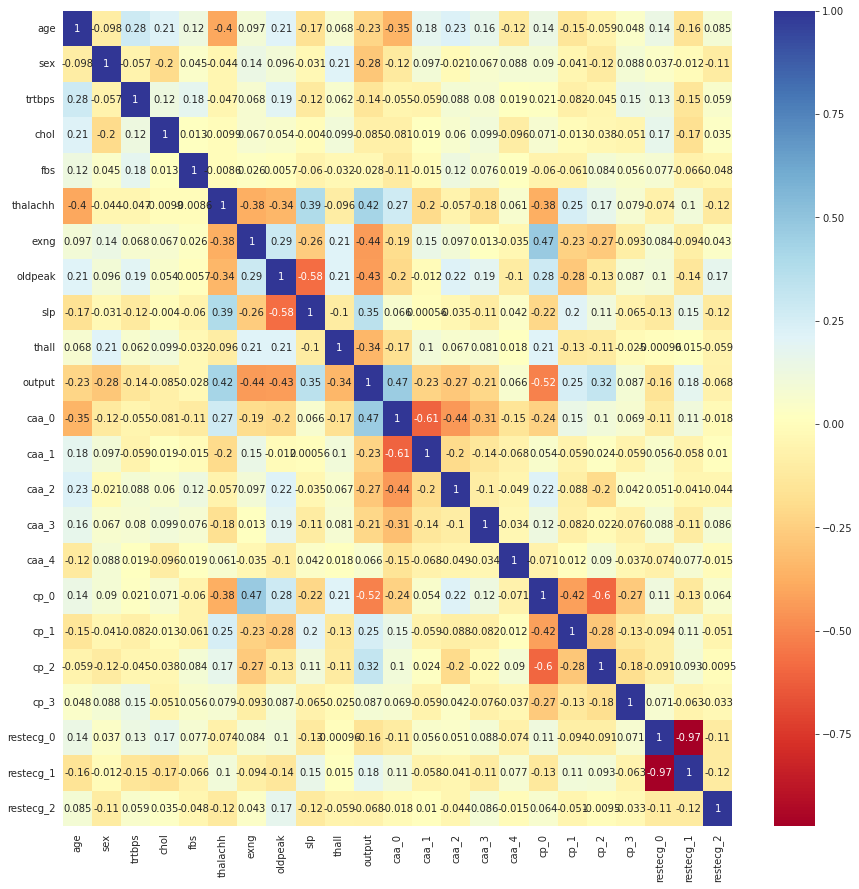

In [4]:
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr(), cbar=True, annot=True, fmt=".2g", cmap='RdYlBu')

In the column output we can see that there are some quite high / low correlations, like:
 - `caa_0` 0.47
 - `thalachh` 0.42
 - `slp` 0.35
 - `cp_0` -0.52
 - `exng` -0.44

This means that the task of predicting the output (chance of heart attack) should be quite possible

## Training and evaluating basic models with default parameters


In [5]:
models = [LogisticRegression(max_iter=5000), RandomForestClassifier(), SVC(), GaussianProcessClassifier(), KNeighborsClassifier()]
metrics = {
    "auc": roc_auc_score,
    "accuracy": accuracy_score
}

results = []

for model in models:
    model.fit(x_train, y_train)
    pred_test = model.predict(x_test)

    results.append({
        "name": model.__class__.__name__,
        **{
            metric_name: metric_fun(y_test, pred_test)
            for metric_name, metric_fun in metrics.items()
        }
    })

results = pd.DataFrame(results).set_index(["name"])
results

,auc,accuracy
name,,
LogisticRegression,0.851293,0.852459
RandomForestClassifier,0.820043,0.819672
SVC,0.818427,0.819672
GaussianProcessClassifier,0.816810,0.819672
KNeighborsClassifier,0.835668,0.836066


As we can see from the results above, the RandomForestClassifier achieves the best results which is > 0.86 AUC.